# Baseline notebook
### Notebook containing the baseline and its results
### Inspired by windgrid paper by Andrade and Bessa

In [12]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

import __fix_relative_imports  # noqa: F401

from mscEidalVesetrudUnofficial.baseline.cross_validation import CrossValidation
from mscEidalVesetrudUnofficial.baseline.lightgbm_model import LightGBMModel
from mscEidalVesetrudUnofficial.baseline.data_prep.paper_features import PaperFeatures
from mscEidalVesetrudUnofficial.data_preprocessing.prod_preprocessing import get_adjusted_prod_data
from mscEidalVesetrudUnofficial.global_constants import DATA_FOLDER, START_TIME, TEST_SPLIT_TIME, END_TIME, TRAIN_SIZE, VAL_SIZE

In [13]:
cv = CrossValidation(
    print_feature_importance=True,
)

## Data handling

In [14]:
# prod (target) data

verbose = False

prod_df = get_adjusted_prod_data(
    start_time=START_TIME,
    end_time=END_TIME,
    verbose=verbose,
    baseline=True,
)
prod_df

,prod
2021-02-09 16:00:00,0.617428
2021-02-09 17:00:00,13.284418
2021-02-09 18:00:00,51.004493
2021-02-09 19:00:00,50.522328
2021-02-09 20:00:00,55.402254
...,...
2025-04-04 20:00:00,91.044426
2025-04-04 21:00:00,56.774327
2025-04-04 22:00:00,31.200693
2025-04-04 23:00:00,55.680136


In [15]:
# NWP (input) data

lags_and_leads_df = pd.read_csv(
    f"{DATA_FOLDER}/processed_lags_and_leads.csv", index_col=0)
print("Lags and leads: ", lags_and_leads_df.shape)
temporal_variance_df = pd.read_csv(
    f"{DATA_FOLDER}/processed_temporal_var.csv", index_col=0)
print("Temporal variance: ", temporal_variance_df.shape)
spatial_smoothing_df = pd.read_csv(
    f"{DATA_FOLDER}/processed_spatial_smoothing.csv", index_col=0)
print("Spatial smoothing: ", spatial_smoothing_df.shape)
spatial_std_df = pd.read_csv(
    f"{DATA_FOLDER}/processed_spatial_std.csv", index_col=0)
print("Spatial std: ", spatial_std_df.shape)
pca_df = pd.read_csv(
    f"{DATA_FOLDER}/processed_wind_components_for_pca.csv", index_col=0)
print("PCA: ", pca_df.shape)

# combine the columns from all the dataframes
data_combined = pd.concat(
    [lags_and_leads_df, temporal_variance_df, spatial_smoothing_df, spatial_std_df],
    axis=1,
)
data_combined.dropna(inplace=True)

data_combined.index = pd.to_datetime(data_combined.index)
data_combined["hour"] = data_combined.index.hour

data_combined = data_combined.merge(
    prod_df[["prod"]], left_index=True, right_index=True, how="inner"
)

pca_df.index = pd.to_datetime(pca_df.index)
pca_df.dropna(inplace=True)
pca_df = pca_df.loc[data_combined.index]

data_combined

Lags and leads:  (44328, 105)
Temporal variance:  (44328, 45)
Spatial smoothing:  (44328, 9)
Spatial std:  (44328, 15)
PCA:  (44328, 2028)


,u_10m_roan_lag_0,u_10m_roan_lag_1,u_10m_roan_lag_2,u_10m_roan_lag_3,u_10m_roan_lead_1,u_10m_roan_lead_2,u_10m_roan_lead_3,u_120m_roan_lag_0,u_120m_roan_lag_1,u_120m_roan_lag_2,...,wind_direction_cos_120m_spatial_std,wind_direction_cos_80m_spatial_std,wind_direction_sin_10m_spatial_std,wind_direction_sin_120m_spatial_std,wind_direction_sin_80m_spatial_std,wind_speed_10m_spatial_std,wind_speed_120m_spatial_std,wind_speed_80m_spatial_std,hour,prod
2021-02-09 16:00:00,3.326006,2.945394,3.997055,3.154320,2.694265,2.055684,-0.035190,3.829525,9.942796,8.631667,...,0.614629,0.489017,0.439720,0.444307,0.484193,2.628243,2.401239,2.058576,16,0.617428
2021-02-09 17:00:00,2.694265,3.326006,2.945394,3.997055,2.055684,-0.035190,-0.331128,1.024838,3.829525,9.942796,...,0.639356,0.586621,0.485298,0.748966,0.711059,2.282197,1.173536,1.073367,17,13.284418
2021-02-09 18:00:00,2.055684,2.694265,3.326006,2.945394,-0.035190,-0.331128,-0.278179,-2.761896,1.024838,3.829525,...,0.584085,0.582184,0.518894,0.495312,0.481588,1.477083,1.827556,1.634326,18,51.004493
2021-02-09 19:00:00,-0.035190,2.055684,2.694265,3.326006,-0.331128,-0.278179,-1.180850,-3.426816,-2.761896,1.024838,...,0.065441,0.080042,0.541012,0.089066,0.102070,1.149596,1.659634,1.718647,19,50.522328
2021-02-09 20:00:00,-0.331128,-0.035190,2.055684,2.694265,-0.278179,-1.180850,-2.164749,-5.010057,-3.426816,-2.761896,...,0.072391,0.107979,0.567614,0.076607,0.097002,1.012184,1.400959,1.523722,20,55.402254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-04 20:00:00,0.803349,2.956314,6.299526,8.546186,-0.406832,0.367537,1.350236,0.882438,2.129266,4.552678,...,0.048196,0.052871,0.192621,0.202587,0.211491,1.381187,0.870593,0.983139,20,91.044426
2025-04-04 21:00:00,-0.406832,0.803349,2.956314,6.299526,0.367537,1.350236,1.242681,-0.469841,0.882438,2.129266,...,0.013002,0.014966,0.201485,0.134724,0.142938,1.465327,0.943423,1.056468,21,56.774327
2025-04-04 22:00:00,0.367537,-0.406832,0.803349,2.956314,1.350236,1.242681,0.330400,0.098408,-0.469841,0.882438,...,0.022390,0.032806,0.287740,0.151322,0.178374,1.514403,0.951806,1.052935,22,31.200693
2025-04-04 23:00:00,1.350236,0.367537,-0.406832,0.803349,1.242681,0.330400,1.617775,2.015655,0.098408,-0.469841,...,0.049261,0.068583,0.316764,0.133387,0.156671,1.118620,1.028903,1.254452,23,55.680136


In [16]:
def run_baseline(
        train: pd.DataFrame,
        test: pd.DataFrame,
        pca_data: pd.DataFrame = None,
        pca_split: bool = False,
        remove_negative: bool = False,
        print_feature_importance: bool = True,
    ) -> tuple[list[tuple[float, float]], pd.DataFrame, pd.DataFrame, LightGBMModel]:
        """
        This function performs a test using the LightGBM model on the given
        train and test data. It uses the PaperFeatures class to perform PCA
        on the data if pca_data is provided. The function returns the results
        of the test, including the train and test scores, and the predictions
        made by the model. The function also prints the feature importances
        of the model if print_feature_importance is set to True. The function
        """
        model = LightGBMModel()
        results = []

        pf = PaperFeatures(power_plant="roan", path_prefix="")

        if pca_data is not None:
            print("performing local PCA")
            
            pca_train, pca_test = pf.principal_component_analysis_train_and_test(
                train.index, test.index, pca_data, pca_split
            )
            train = pd.concat([train, pca_train], axis=1, join="inner")
            test = pd.concat([test, pca_test], axis=1, join="inner")

        train_score, test_score, predictions = model.test_model(
            train, test, remove_negative=remove_negative
        )
        results.append((train_score, test_score))

        if print_feature_importance:
            model.print_feature_importances()

        return results, predictions

## Model run

performing local PCA
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53829
[LightGBM] [Info] Number of data points in the train set: 25462, number of used features: 212
[LightGBM] [Info] Start training from score 97.549465


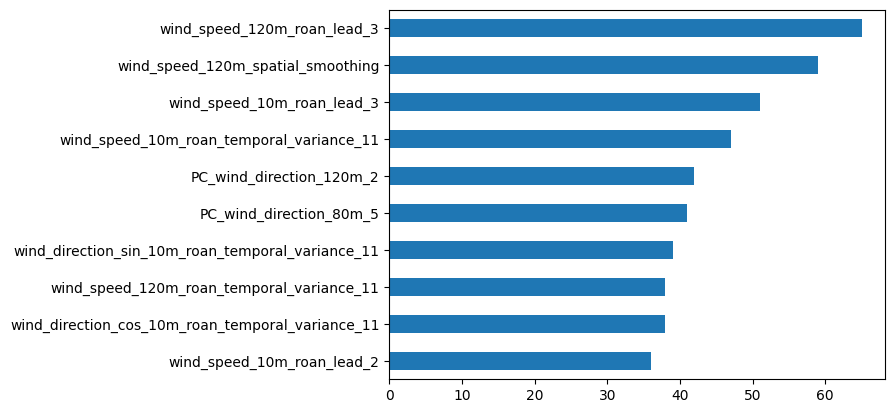

Average MAE: 23.887292255739997


In [17]:
%matplotlib inline

data_combined_copy = data_combined.copy()
data_combined_copy["prod"] = data_combined_copy["prod"].clip(lower=0)

results, f_predictions = run_baseline(
    train=data_combined_copy.loc[
        :TEST_SPLIT_TIME
    ], # all train data up to TEST_SPLIT_TIME
    test=data_combined_copy.loc[
        TEST_SPLIT_TIME:END_TIME
    ], # full test set [TEST_SPLIT_TIME:END_TIME]
    pca_data=pca_df,
    pca_split=False,
    remove_negative=True,
)
f_predictions.columns = ["f_pred"]

f_results_df = pd.DataFrame(results, columns=["mae", "mse"])
f_mae = f_results_df["mae"].mean()
f_mse = f_results_df["mse"].mean()
print("Average MAE:", f_mae)